In [1]:
import os
import shutil
import random
import numpy as np

curr_dir = os.getcwd()

data_folder = os.path.join(curr_dir, "data")
train_folder = os.path.join(curr_dir, "train")
test_folder = os.path.join(curr_dir, "test")

# List all folders in the data directory
folders = os.listdir(data_folder)

# Shuffle the folders
random.shuffle(folders)

# Calculate the split index
split_index = int(0.6 * len(folders))

# Split folders into train and test sets
train_folders = folders[:split_index]
test_folders = folders[split_index:]

# Function to move data into train or test directory
def move_data(source_folder, dest_folder, folders):
    for folder in folders:
        source_path = os.path.join(source_folder, folder)
        dest_path = os.path.join(dest_folder, folder)
        shutil.move(source_path, dest_path)

# Move train data
move_data(data_folder, train_folder, train_folders)

# Move test data
move_data(data_folder, test_folder, test_folders)


In [2]:
from PIL import Image

# Load data from the folder structure.
# takes folder_path: Path to the main folder containing subfolders with images
# Returns input_mix: List of input mix spectrogram images and sources: List of 
# lists, where each inner list contains three source 
# spectrogram images corresponding to each input mix
def load_data(folder_path, desired_width, desired_height):

    input_mix = []
    sources = []

    # Iterate through each folder in the main folder
    for folder in os.listdir(folder_path):
        folder_name = folder.split("_")[1]  # Extract id_x from folder name
        
        if os.path.isdir(os.path.join(folder_path, folder)):
            input_mix_path = os.path.join(folder_path, folder, f"id_{folder_name}_mix.png")
            source_music_path = os.path.join(folder_path, folder, f"id_{folder_name}_music.png")
            source_sp0_path = os.path.join(folder_path, folder, f"id_{folder_name}_sp0.png")
            source_sp1_path = os.path.join(folder_path, folder, f"id_{folder_name}_sp1.png")
            
            # Load images
            input_mix_img = Image.open(input_mix_path).convert("RGB")
            source_music_img = Image.open(source_music_path).convert("RGB")
            source_sp0_img = Image.open(source_sp0_path).convert("RGB")
            source_sp1_img = Image.open(source_sp1_path).convert("RGB")

            # Resize images if needed
            input_mix_img = input_mix_img.resize((desired_width, desired_height))
            source_music_img = source_music_img.resize((desired_width, desired_height))
            source_sp0_img = source_sp0_img.resize((desired_width, desired_height))
            source_sp1_img = source_sp1_img.resize((desired_width, desired_height))

            # Convert images to numpy arrays and normalize pixel values
            input_mix_arr = np.array(input_mix_img) / 255.0
            source_music_arr = np.array(source_music_img) / 255.0
            source_sp0_arr = np.array(source_sp0_img) / 255.0
            source_sp1_arr = np.array(source_sp1_img) / 255.0

            # Append to lists
            input_mix.append(input_mix_arr)
            sources.append([source_music_arr, source_sp0_arr, source_sp1_arr])

    return input_mix, sources

## NOTE USE 496 width and 369 height to use efficientnet model same way as paper
train_input_mix, train_sources = load_data(train_folder, 256, 256)
test_input_mix, test_sources = load_data(test_folder, 256, 256)

# Convert lists to numpy arrays
train_input_mix = np.array(train_input_mix)
train_sources = np.array(train_sources)

test_input_mix = np.array(test_input_mix)
test_sources = np.array(test_sources)


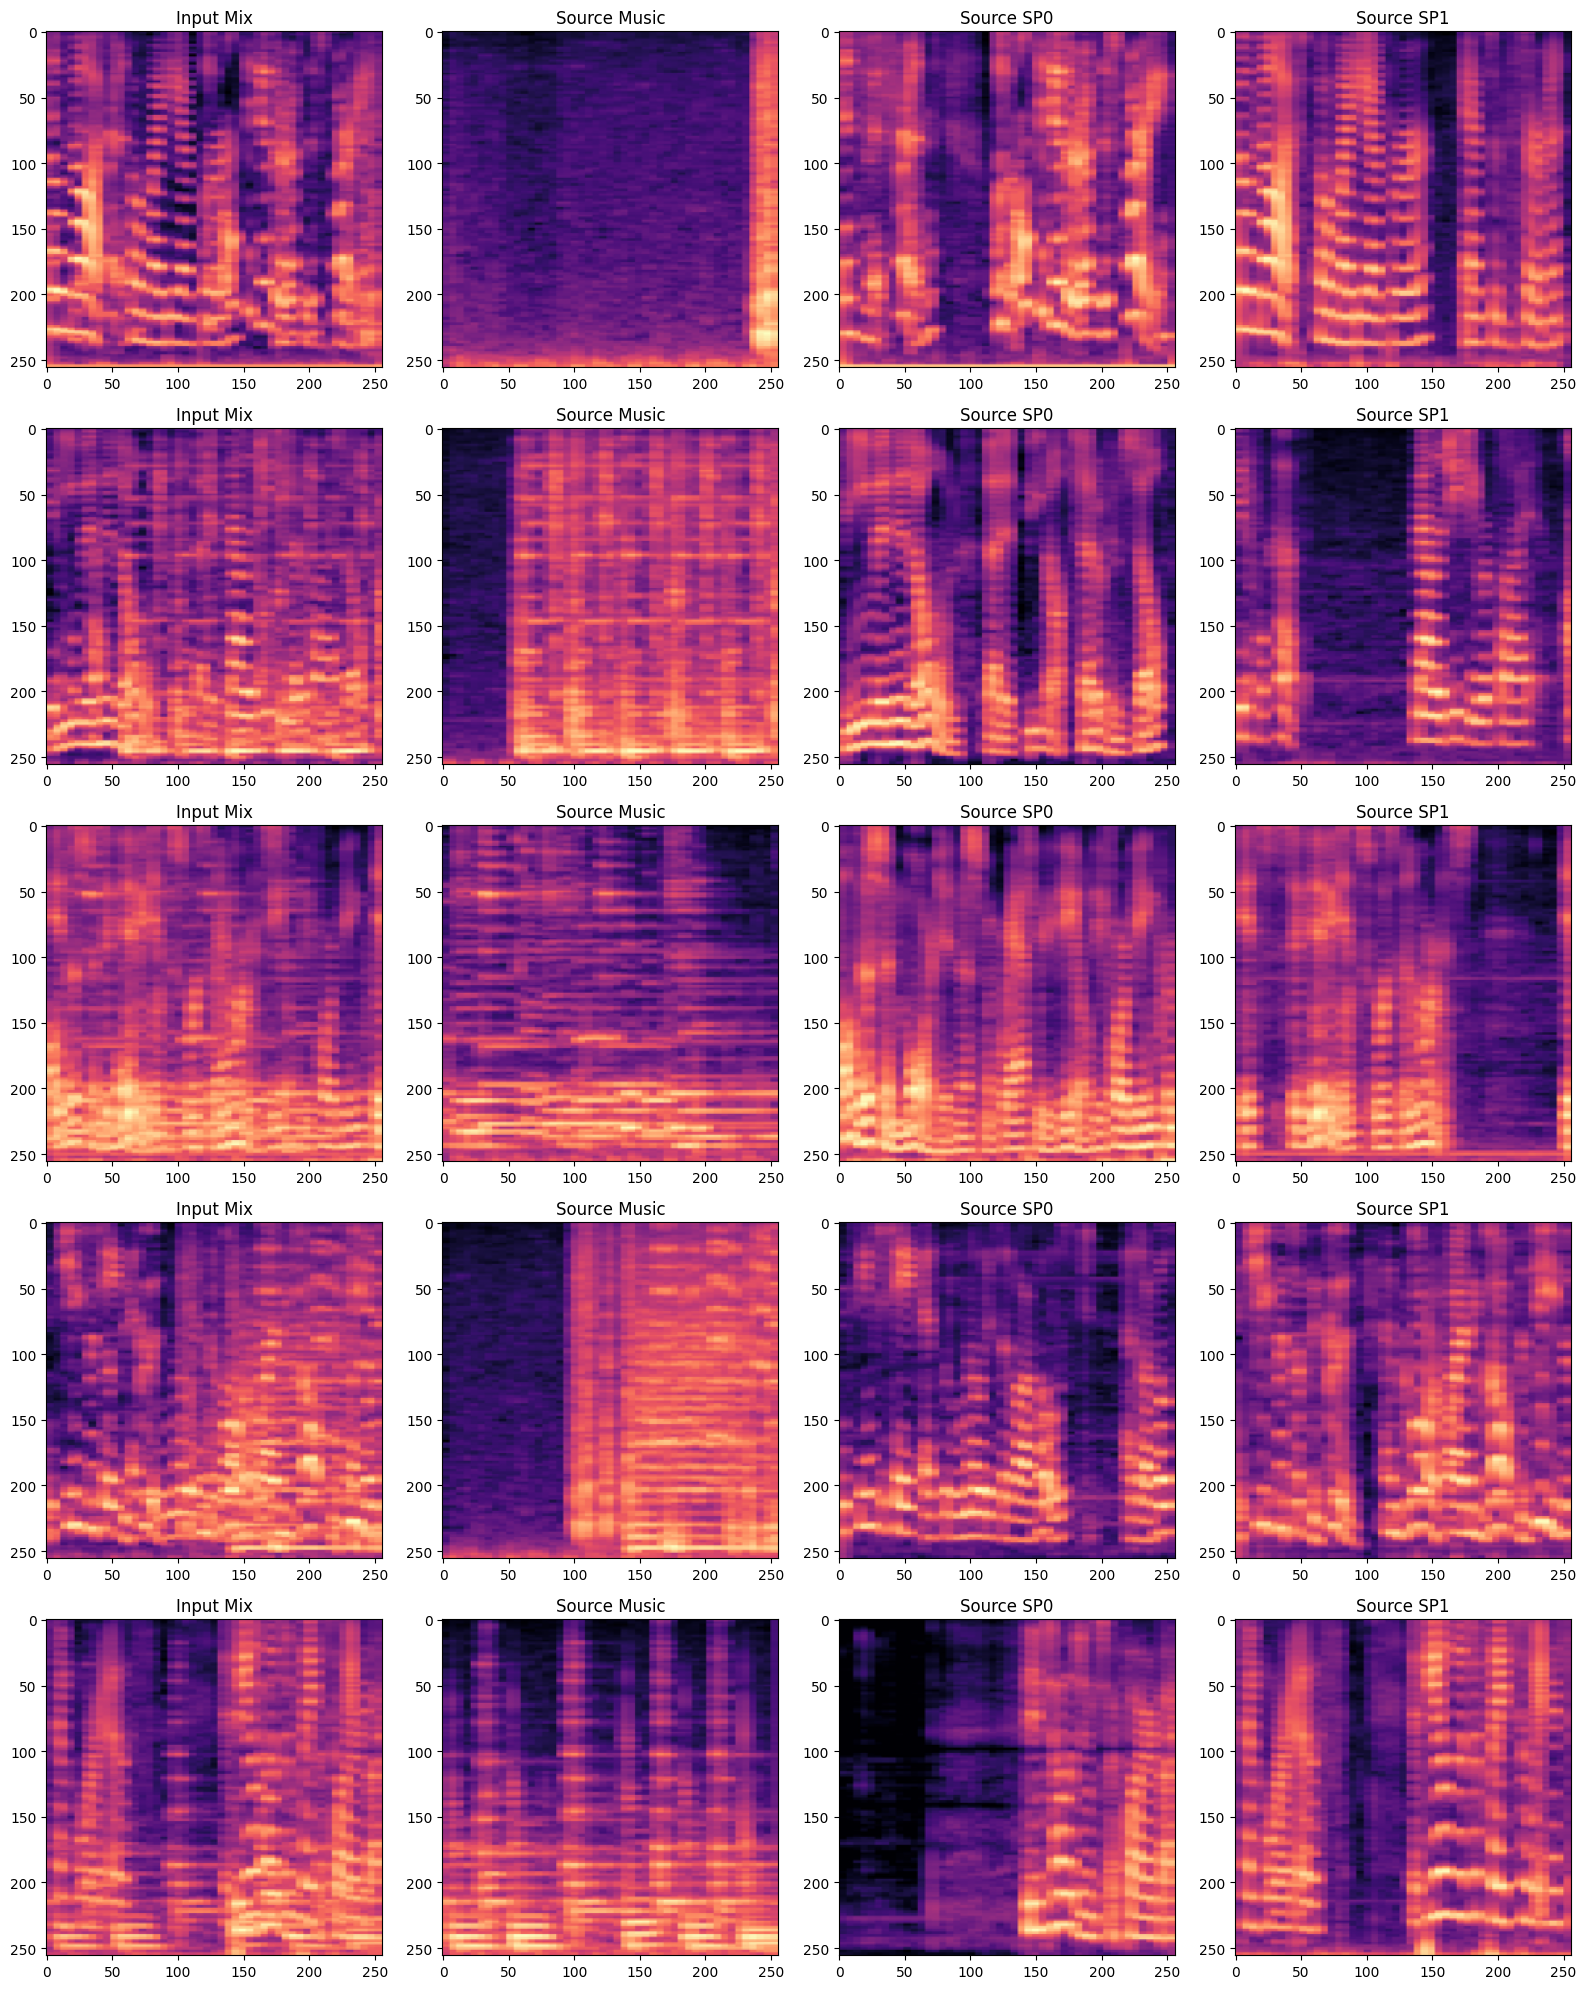

In [13]:
import matplotlib.pyplot as plt

# Visualize a few input mix and source images
num_samples = len(test_input_mix)
num_visualize = min(5, num_samples)  

fig, axes = plt.subplots(num_visualize, 4, figsize=(16, num_visualize * 4))

for i in range(num_visualize):
    input_mix_img = test_input_mix[i]
    source_music_img, source_sp0_img, source_sp1_img = test_sources[i]
    
    axes[i, 0].imshow(input_mix_img)
    axes[i, 0].set_title(f'Input Mix')    

    axes[i, 1].imshow(source_music_img)
    axes[i, 1].set_title('Source Music')

    axes[i, 2].imshow(source_sp0_img)
    axes[i, 2].set_title('Source SP0')

    axes[i, 3].imshow(source_sp1_img)
    axes[i, 3].set_title('Source SP1')

plt.tight_layout()
plt.show()


In [3]:
# Create TensorFlow Dataset objects
import tensorflow as tf
print("Train input mix shape:", train_input_mix.shape)
print("Train sources shape:", train_sources.shape)  # extra 3 just means we have 3 targets
print("Train input mix dtype:", train_input_mix.dtype)
print("Train sources dtype:", train_sources.dtype)

print("Test input shape", test_input_mix.shape)
print("Test sources shape:", test_sources.shape)  # extra 3 just means we have 3 targets
print("Test input mix dtype:", test_input_mix.dtype)
print("Test sources dtype:", test_sources.dtype)


gpu_devices = tf.config.experimental.list_physical_devices("GPU") # to solve overfilling VRAM - didnt work - reducing image size worked! - but now it runs OOM during training...
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

batch_size = 32  # Adjust as needed 

train_dataset = tf.data.Dataset.from_tensor_slices((train_input_mix, train_sources)).shuffle(buffer_size=len(train_input_mix)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_input_mix, test_sources)).batch(batch_size)

Train input mix shape: (480, 256, 256, 3)
Train sources shape: (480, 3, 256, 256, 3)
Train input mix dtype: float64
Train sources dtype: float64
Test input shape (320, 256, 256, 3)
Test sources shape: (320, 3, 256, 256, 3)
Test input mix dtype: float64
Test sources dtype: float64


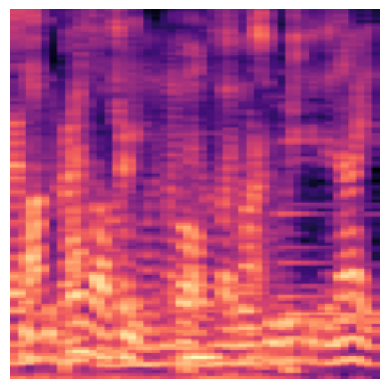

In [5]:
# making sure tensors are right

# Retrieve a batch of tensors from the dataset
tensor_batch = next(iter(train_dataset))    

# Select the first tensor from the batch
tensor_slice = tensor_batch[0][2]   # [0] is the batch of 32, (set above) need another [0] to grab first in that batch

# Ensure the tensor is in the correct format for plotting
tensor_slice = np.clip(tensor_slice, 0, 1)  # Clip values to range [0, 1]
tensor_slice *= 255  # Scale to [0, 255]

# Plot the tensor slice as an image
plt.imshow(tensor_slice.astype(np.uint8))  # Convert to uint8 for plotting
plt.axis('off')  # Turn off axis
plt.show()


In [6]:
## CNN with effnet as base model
import math
from keras import layers
from keras.layers import Conv2D, UpSampling2D, Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from keras import Model
from keras import models
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import LearningRateScheduler

# preprocessing the input according to efficientnet was causing issues
#preprocessed_images = preprocess_input(train_dataset) 
#preprocessed_images = preprocess_input(test_dataset)

img_height = 256    # change to 369 to recreate paper results
img_width = 256     # change to 496 to recreate paper results
num_channels = 3    # RGB
input_shape = (img_height, img_width, num_channels)

train_samples = 480
test_samples = 320

pre_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = "imagenet",
    input_shape = input_shape
)

# freeze base
pre_model.trainable = False

# Add custom layers on top
x = layers.GlobalAveragePooling2D()(pre_model.output)
x = layers.Dense(512, activation='relu')(x)

# Output layers for three spectrograms
output1 = layers.Dense(img_height * img_width * 3, activation='sigmoid')(x)  # this is adding a HUGE amount of complexity & trainable params
output2 = layers.Dense(img_height * img_width * 3, activation='sigmoid')(x)
output3 = layers.Dense(img_height * img_width * 3, activation='sigmoid')(x)

# Reshape outputs to match spectrogram size
output1 = tf.reshape(output1, (-1, img_height, img_width, 3))
output2 = tf.reshape(output2, (-1, img_height, img_width, 3))
output3 = tf.reshape(output3, (-1, img_height, img_width, 3))

# Define model
model = Model(inputs=pre_model.input, outputs=[output1, output2, output3])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
# demucs - like model
import math
from keras import layers
from keras.layers import Conv2D, UpSampling2D, Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from keras import Model
from keras import models
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import LearningRateScheduler

img_height = 256    # because we resized them when we loaded them earlier
img_width = 256
num_channels = 3    # RGB
input_shape = (img_height, img_width, num_channels)

train_samples = 480
test_samples = 320

num_sources = 3

# Input layer
inputs = Input(shape=input_shape)

# Encoder blocks
conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# Decoder blocks with skip connections
up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(pool2)
concat1 = Concatenate()([conv2, up1])
conv3 = Conv2D(128, 3, activation='relu', padding='same')(concat1)
up2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv3)
concat2 = Concatenate()([conv1, up2])
conv4 = Conv2D(64, 3, activation='relu', padding='same')(concat2)

# Output layers for each source
outputs = [Conv2D(3, 3, activation='sigmoid', padding='same')(conv4) for _ in range(num_sources)]

# Create model
model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                           

In [10]:
# U-NET like model
import math
from keras import layers
from keras.layers import Conv2D, UpSampling2D, Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from keras import Model
from keras import models
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import LearningRateScheduler

img_height = 256    # because we resized them when we loaded them earlier
img_width = 256
num_channels = 3    # RGB
input_shape = (img_height, img_width, num_channels)

train_samples = 480
test_samples = 320

num_sources = 3

img_shape = (img_height, img_width, num_channels) # 3 because RGB

def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder




# Input 256 x 256
inputs = layers.Input(shape=img_shape)
# encoder
encoder2_pool, encoder2 = encoder_block(inputs, 16)
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 32)
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 64)

# center, bottleneck layer
center = conv_block(encoder4_pool, 128)
print(center.shape)
print(encoder4.shape)

# decoder
decoder4 = decoder_block(center, encoder4, 64)
decoder3 = decoder_block(decoder4, encoder3, 32)
decoder2 = decoder_block(decoder3, encoder2, 16)

# output
#outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(decoder2)
outputs = [Conv2D(3, (1,1), activation='sigmoid', padding='same')(decoder2) for _ in range(num_sources)]

# Define model
model = models.Model(inputs=[inputs], outputs=[outputs])

model.summary()

(None, 32, 32, 128)
(None, 64, 64, 64)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 256, 256, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_68 (BatchN  (None, 256, 256, 16  64         ['conv2d_68[0][0]']              
 ormalization)                  )                    

In [11]:
def custom_mse(y_true, y_pred):
    # Compute separate losses for each source
    losses = []
    for i in range(3):  # because 3 sources
        # 3 outputs to compare to 3 sources
        # print(y_true[:, i].shape)
        # print(y_pred[i].shape)
        loss = tf.losses.mean_squared_error(y_true[:, i], y_pred[i])
        losses.append(loss)

    # Combine losses (e.g., mean or sum)
    total_loss = tf.reduce_mean(losses) 

    return total_loss

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=custom_mse)

## callbacks
# model checkpoint
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', mode='min', save_best_only=True)  # SDR loss is better higher

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Monitor the validation loss
                                        patience=6,          # Number of epochs with no improvement after which training will be stopped
				        restore_best_weights=True)      # Restore best weights from that period

# learning rate scheduler
def scheduler(epoch, lr):
	initial_lrate = 0.01
	drop = 0.1
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lr_schedule = LearningRateScheduler(scheduler)

history = model.fit(
      train_dataset,
      steps_per_epoch=int(np.ceil(train_samples / float(batch_size))),
      epochs=10,
      validation_data=test_dataset,
      validation_steps=int(np.ceil(test_samples / float(batch_size))),
      callbacks = [cp, es, lr_schedule],
      verbose=1)

Epoch 1/10
15/15 [==============================] - 84s 6s/step - loss: 0.1614 - conv2d_82_loss: 0.0473 - conv2d_83_loss: 0.0562 - conv2d_84_loss: 0.0580 - val_loss: 0.7654 - val_conv2d_82_loss: 0.2234 - val_conv2d_83_loss: 0.2233 - val_conv2d_84_loss: 0.3187 - lr: 0.0100
Epoch 2/10
15/15 [==============================] - 81s 5s/step - loss: 0.1146 - conv2d_82_loss: 0.0380 - conv2d_83_loss: 0.0383 - conv2d_84_loss: 0.0383 - val_loss: 0.8242 - val_conv2d_82_loss: 0.3775 - val_conv2d_83_loss: 0.2233 - val_conv2d_84_loss: 0.2233 - lr: 0.0100
Epoch 3/10
15/15 [==============================] - 81s 5s/step - loss: 0.1119 - conv2d_82_loss: 0.0370 - conv2d_83_loss: 0.0376 - conv2d_84_loss: 0.0372 - val_loss: 0.7818 - val_conv2d_82_loss: 0.3513 - val_conv2d_83_loss: 0.2228 - val_conv2d_84_loss: 0.2077 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 81s 5s/step - loss: 0.1126 - conv2d_82_loss: 0.0373 - conv2d_83_loss: 0.0378 - conv2d_84_loss: 0.0375 - val_loss: 0.6176 - val_co

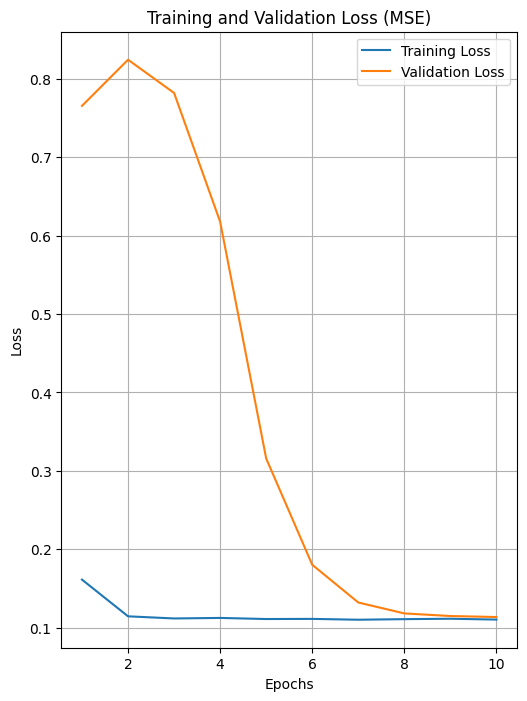

In [14]:
def plot_history(history, SKIP):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range[SKIP:], loss[SKIP:], label='Training Loss')
    plt.plot(epochs_range[SKIP:], val_loss[SKIP:], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()

    plt.show()

plot_history(history, 0)

Fine tuning

In [11]:
# do fine tuning here

Showing off some y_pred

10/10 [==============================] - 10s 978ms/step


TypeError: Invalid shape (320, 256, 256, 3) for image data

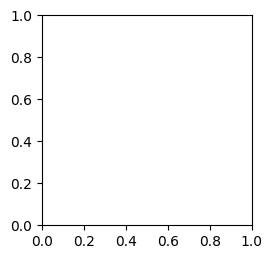

In [15]:
def display_predictions(dataset, model):
    # Make predictions on the dataset
    y_pred = model.predict(dataset)
    
    # Take two random examples
    num_samples = len(y_pred[0])
    sample_indices = np.random.choice(num_samples, size=2, replace=False)
    
    # Iterate over the selected examples
    for sample_index in range(len(y_pred[0])):
        # Display prediction
        plt.figure(figsize=(12, 6))
        for i in range(len(y_pred)):
            plt.subplot(2, len(y_pred), i+1)
            plt.imshow(y_pred[i][sample_index])
            plt.title(f'Output {i+1}')
            plt.axis('off')
        
        plt.show()

display_predictions(test_dataset, model)

10/10 [==============================] - 10s 988ms/step


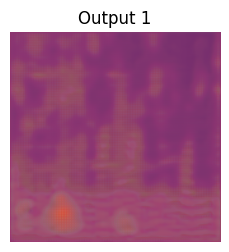

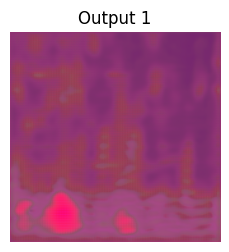

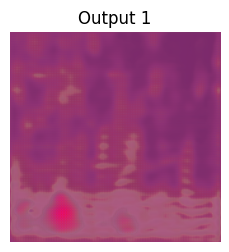

In [16]:
# For printing the U-Net output
def display_predictions(dataset, model):
    # Make predictions on the dataset
    y_pred = model.predict(dataset)
    
    # Take two random examples
    num_samples = len(y_pred[0])
    sample_indices = np.random.choice(num_samples, size=2, replace=False)
    
    # Iterate over the selected examples
    for sample_index in range(len(y_pred[0])):
        # Display prediction
        plt.figure(figsize=(12, 6))
        for i in range(len(y_pred)):
            for j in range(3):
                plt.subplot(2, len(y_pred), i+1)
                plt.imshow(y_pred[i][sample_index][j])
                plt.title(f'Output {i+1}')
                plt.axis('off')
        
        plt.show()

display_predictions(test_dataset, model)